# Spatial clustering

### Goal: to cluster the wells regionally in order to capture geological information

### Acknowledgments:
#### - [Brendon Hall](https://github.com/brendonhall/FORCE-2020-Lithology/blob/master/notebooks/02-Map-View.ipynb)
#### - [Matteo Niccoli](https://github.com/mycarta/Force-2020-Machine-Learning-competition_predict-lithology-EDA/blob/master/GMM_clustering_of_spatial_location.ipynb)

## Loading data

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import mixture
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
load_dotenv()

True

In [2]:
data_path = os.environ.get("DATA_PATH")

In [3]:
data = pd.read_csv(data_path+'/force_2020_meta.csv')

In [4]:
LonLat_df =  data.drop(['WELL', 'WELL_HEAD', 'Drilling Operator', 'Purpose', 'Completion Year', 'Formation', 'Dataset'], axis=1)
X=LonLat_df[['lon', 'lat']].values

## kMeans

In [9]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=3425)

In [10]:
def plot_kmeans(kmeans, X, ax=None):
    
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c = labels, s=60, cmap='viridis', zorder=1, alpha = 0.7)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c = 'g', s = 300, zorder=1)
    ax.scatter(centers[:, 0], centers[:, 1], c = 'k', s = 100, zorder=2)
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='lightgray', lw=2, alpha=0.4, zorder=0))

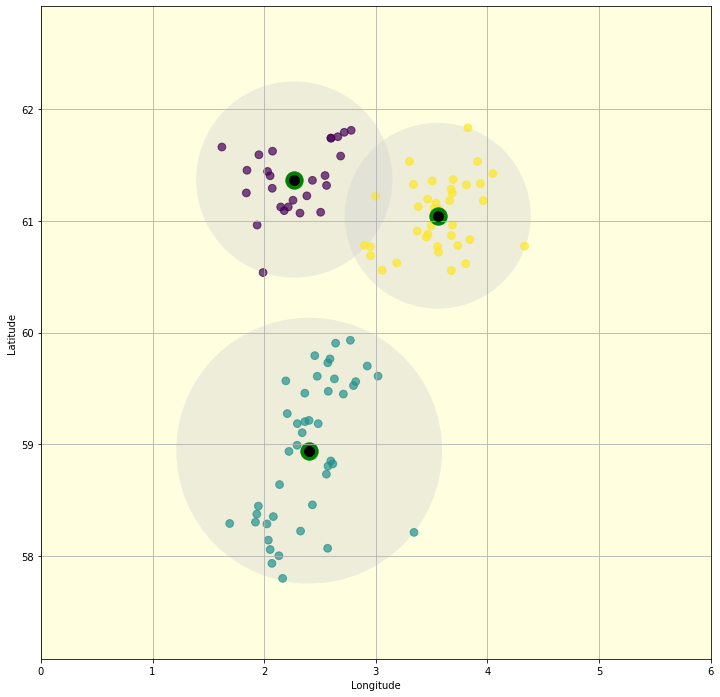

In [12]:
fig = plt.figure(figsize=((12,12)))
plot_kmeans(kmeans, X)
ax = plt.gca()
ax.set_facecolor('lightyellow')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid()

## Gaussian Mixture Model

In [5]:
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=2698).fit(X)

#### PLOTS

In [11]:
labels = gmm.predict(X)+1

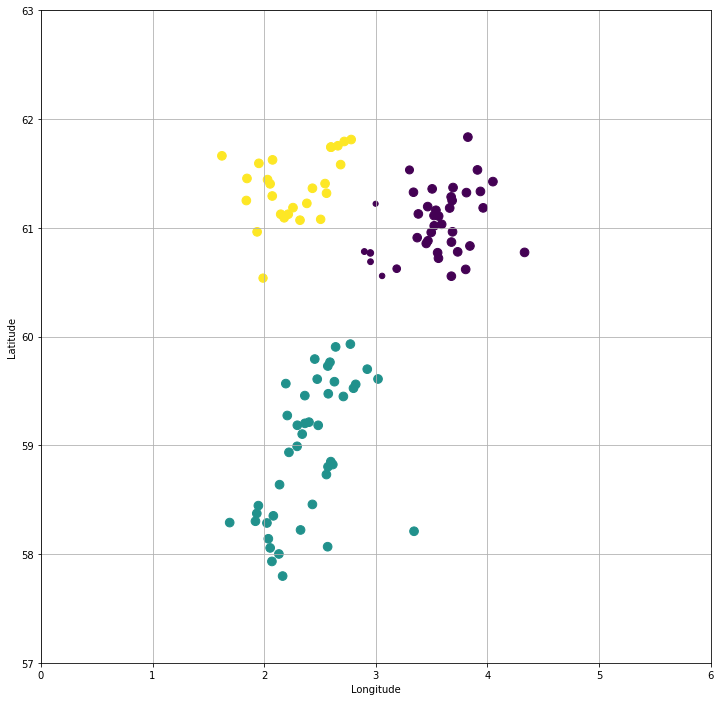

In [12]:
fig = plt.figure(figsize=(12,12))
sizes = 75 * probs.max(1) ** 5 
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=sizes)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid()

In [13]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    fig = plt.figure(figsize=((12,12)))
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)

    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor, facecolor = 'darkgreen', edgecolor ='darkslategray')

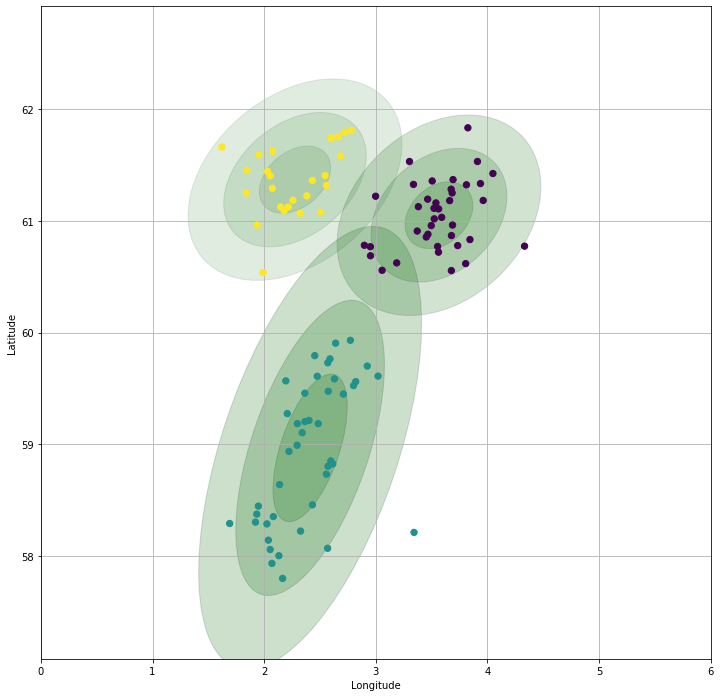

In [14]:
plot_gmm(gmm, X)
ax = plt.gca()
ax.set_facecolor('white')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_xlim(0,6)
ax.set_ylim(57,63)
plt.grid()

In [15]:
probs_str=[]
for i in probs:
    probs_str.append([str(j) for j in np.round(i, 3)])

In [16]:
data_gmm = data.copy()

In [17]:
data_gmm['probs_str'] = probs_str
data_gmm['cluster'] = labels
data_gmm['plot_size']= sizes
data_gmm['cluster1_prob'], data_gmm['cluster2_prob'], data_gmm['cluster3_prob'] = np.round(probs.T, 3)

In [18]:
columns = list(data)+[ 'cluster', 'color', 'plot_size', 'probs_str',
                      'cluster1_prob', 'cluster1_prob', 'cluster1_prob']

In [30]:
df_gmm = data_gmm.drop(columns=['WELL_HEAD', 'lat', 'lon', 'Drilling Operator', 'Purpose', 'Completion Year', 'Formation'])

In [29]:
null_data = data_gmm[data_gmm.isnull().any(axis=1)]

,WELL,WELL_HEAD,lat,lon,Drilling Operator,Purpose,Completion Year,Formation,Dataset,probs_str,cluster,plot_size,cluster1_prob,cluster2_prob,cluster3_prob
9,16/11-1 ST3,16/11-1,58.067778,2.568889,NaN,NaN,NaN,NaN,Train,"[0.0, 1.0, 0.0]",2,75.000000,0.0,1.0,0.0
22,25/2-13 T4,25/2-13,59.793803,2.453478,NaN,NaN,NaN,NaN,Train,"[0.0, 1.0, 0.0]",2,74.989485,0.0,1.0,0.0


### Integrating cluster feature in initial training set

In [ ]:
df_clusters = df_clusters[df_clusters.Dataset == 'Train']

In [ ]:
clusters = df_clusters[['WELL', 'cluster']]

In [ ]:
df_train_cluster = df_train.merge(clusters, how='left', on='WELL', validate='many_to_one')

### Write the updated train dataset

In [29]:
data_gmm.to_csv(data_path+'/clusters_gaussian-mixture-model_3components.csv', sep=',')

### References
Bormann P., Aursand P., Dilib F., Dischington P., Manral S. (2020) 2020 FORCE Machine Learning Contest. https://github.com/bolgebrygg/Force-2020-Machine-Learning-competition